# Practical Session 5 - Parallel Markov chains with multiprocessing and dask

Students (pair):
- [Antonin Morel]([link](https://github.com/Cbonvieuxziz))
- [Benjamin Renoux]([link](https://github.com/Ben1306))


**Useful references for this lab**:

[1] `seaborn`: [official tutorial](https://seaborn.pydata.org/tutorial.html)

[2] `multiprocessing`: [documentation](https://docs.python.org/3/library/multiprocessing.html), [doc2](https://he-arc.github.io/livre-python/multiprocessing/index.html)

[3] `dask`: [documentation](http://numba.pydata.org/) 

## <a name="content">Contents</a>
- [Exercise 1: seaborn, a useful tool for data visualisation](#ex1)
- [Exercise 2: Simulating a discrete-time homogeneous Markov chain](#ex2)
- [Bonus: Parallel computing with Dask](#bonus)
---

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <a name="ex1">Exercise 1: seaborn, a useful tool for data visualisation</a> [(&#8593;)](#content)
 
The `seaborn` package can significantly enhance data and data analysis visualization. See the [tutorial page](https://seaborn.pydata.org/tutorial.html) for examples of effective predefined graphics. An example aimed at visualizing the empirical distributions of 9 realizations of a bivariate Gaussian random vector is reported below.

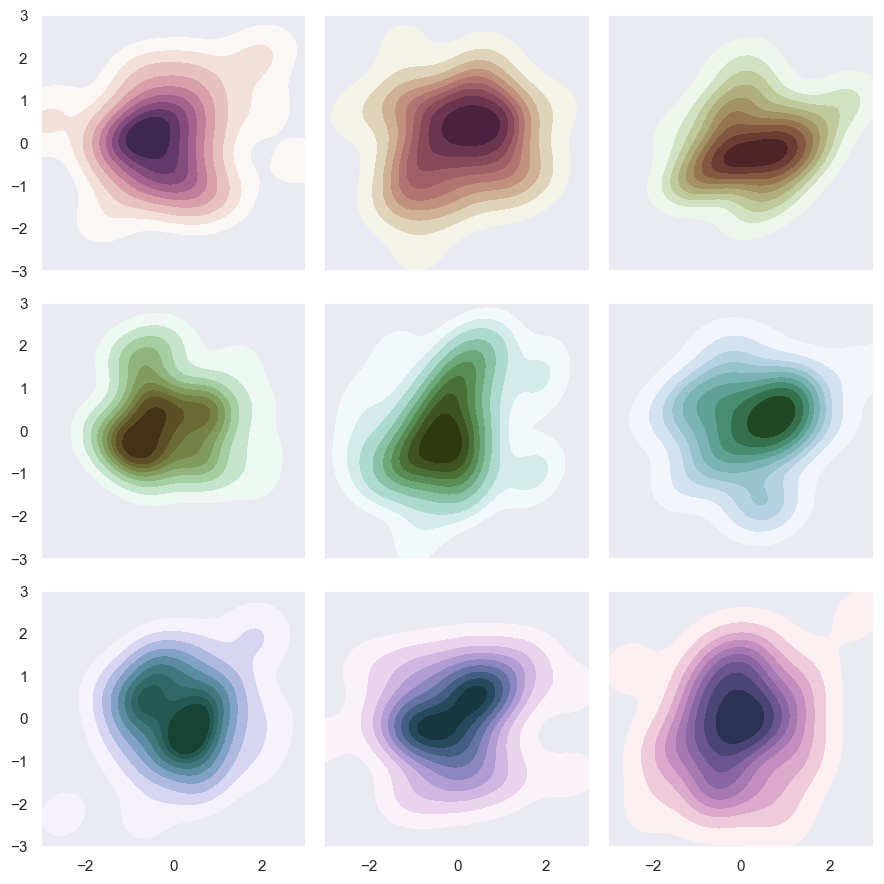

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

sns.set(style="dark")
rng = np.random.default_rng(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rng.normal(size=(2, 50))    
    sns.kdeplot(x=x, y=y, cmap=cmap, fill=True, cut=5, ax=ax)
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()

1. Comment on the lines of codes related to the `seaborn` library to make their role explicit. More specifically comment on the KDE method.

**Answer:**

In [39]:
# sns.set(style="dark")
#   -> Set the axes style to dark

# sns.cubehelix_palette(start=s, light=1, as_cmap=True)
#   -> Returns a palette of color to plot the result
#      The result will be given directly to the plot function

# sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)
#   -> Plot the 2-D data (x,y) on the axe ax 
#   -> Setting the fill (previous shade) to True makes that following statement true: higher density => darker color
#       -> Helps with visualization of the result
#   -> The color map is the one created above

2. For one of the realizations, take a look at the documentation of [`sns.jointplot`](https://seaborn.pydata.org/examples/joint_kde.html) to display both the 2-D empirical distribution of the data, and 1D histograms of their distribution along each axis. 

**Answer:**

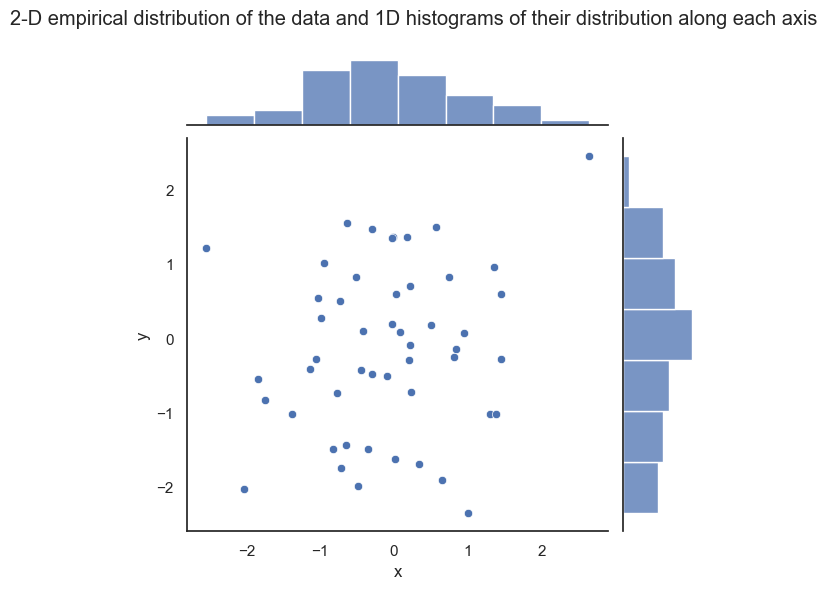

In [40]:
# We use the last data stored in x and y

# Create and DataFrame to name the data
df = pd.DataFrame({'x': x, 'y': y})

# Customize the seaborn style
sns.set(style="white")

# Plot the graph
g = sns.jointplot(data=df, x="x", y="y", kind="scatter", color="b")

# Set graph's title
plt.subplots_adjust(top=0.9)  # Adjust the position of the title
g.fig.suptitle("2-D empirical distribution of the data and 1D histograms of their distribution along each axis")

plt.show()

## <a name="ex2">Exercise 2: Simulating a discrete-time homogeneous Markov chain.</a> [(&#8593;)](#content)


Let ${(X_n)}_{n\geq 0}$ be a discrete-time homogeneous Markov chain with values over a finite ensemble $E=\{x_1,\dots,x_N\}$ identified to $\{1,\dots,N\}$. Consider $\boldsymbol{\rho} \in \Delta_N$, where $\Delta_N = \{\mathbf{x}\in\mathbb{R}^N \mid x_n \geq 0 \, \forall n \in \{1,\dotsc,N\} \text{ and } \sum_n x_n = 1 \}$ is the unit simplex in $\mathbb{R}^N$.

In the following, we consider the initial state of the chain $X_0$, following the discrete probability distribution:

$$
    \mathbb{P}(X_0 = k) = \rho_k, \qquad k \in \{1, \dots,  N\}.
$$
  
Let $\mathbf{A} = [a_{i,j}]_{i,j} \in \mathbb{R}^{N \times N}$ be the transition matrix of the chain, i.e.,

\begin{align*}
    &a_{i,j} = \mathbb{P}(X_{n+1} = j \mid X_{n} = i) \geq 0, \, \forall n \geq 0, \\
    &(\forall i \in \{1, \dotsc, N\}), \quad \sum_{j=1}^N a_{i,j} = 1.
\end{align*}
 
The chain is said to be homogeneous in that $\mathbf{A}$ does not depend from the time index $n$. Let $\tilde{a}_n$ represent the $n$-th row of $\mathbf{A}$. 

The trajectory of the chain can be simulated as follows:

>- Draw the discrete random variable $X_0$ with distribution $\boldsymbol{\rho}$;
>
>- For $q = 0$ to $n_{\text{iter}}-1$
>    - Draw the discrete random variable $X_{q+1}$ with distribution $\tilde{a}_{X_{q}}$;
>    
>- Return ${(X_q)}_{0 \leq q \leq n_{\text{iter}}}$.


<!-- If $X_n = k$, we know that $T$, the life time of the chain in the state $k$ obeys a geometric distribution with parameter $a_{kk}$. We also know that the probability of transition from k to $\ell\neq k$ is given by:

$$
    \mathbb{P}(X_{n+1}=\ell | X_n=k, \ell\neq k) = \frac{a_{k\ell}}{1-a_{kk}}.
$$

 ### One possible algorithm to simulate a Markov chain is therefore:

    a. generate the initial state $X_0$ according to the discrete law $\{\rho_1,\dots,\rho_N\}$.

    b. at instant $n$, knowing that $X_n=k$,

    i) determine the life time $T$ in state $X_n=k$ by simulating a geometrical variable with parameter $a_{kk}$. As a consequence $X_n = \dots = X_{n+T} = k$. When $T=0$, we simply still have $X_n=k$.

    ii) determine next transition instant $n+T$, and determine the next state by using the probabilities of transition. -->

1. Implement the above algorithm in a function `X = markov(rho,A,nmax,rng)` with:
     - `rho`: law of the initial state (nonnegative vector of size $N$, summing to 1),
     - `A`: transition matrix (of size $N\times N$) 
     - `nmax`: number of time steps,
     - `rng`: random number generator
     - `X`: trajectory of the chain.
     
In particular, check the input parameters `A` and `rho` make sense by adding appropriate assertions (or raising exceptions).
   - Examples : **transition matrix `A` should be square** ; **expected `A` to be a stochastic matrix** ; **verify if the size of `A` and `rho` are consistent** ; **verify if `rho` is in the unit simplex**
     - `np.allclose`, `np.isclose` and `np.all` could be useful

> Hints:
> - the function `np.random.choice` can be useful to draw discrete random variables.
> - use `states = np.arange(N)` to create the the labels of the states (from $0$ up to $N-1$)

Here is an example of execution : 
![alternatvie text](img/For_CourseM.png)

**Answer:**

In [41]:
def markov(rho,A,nmax,rng, N):
    '''
    Build a Markov chain

    Params:
        rho: law of the initial state (probability vector)
        A: transition matrix (of size NxN) 
        nmax: number of time steps
        rng: random number generator
        X: trajectory of the chain
    
        returns:
            The path obtained
    '''
    
    def check_parameters(rho, A):
        '''
        Assert the input parameters are valid
        '''
        assert rho.shape == (N,), f"rho has to be a vector of N={N} elements"
        assert np.isclose(sum(rho), 1) and np.all(rho >= 0), "rho have to be in the unit simplex"
        assert A.shape == (N, N), f"A have to be of size NxN ({N}x{N})"
        assert np.all(A>=0) and np.allclose(np.sum(A, axis=1), np.ones((N,))), "A has to be stochastic"
    
    # Check if the parameters match the constraints
    check_parameters(rho, A)

    # Initialization
    X_0 = rng(N, rho)
    path = [X_0]
    
    for _ in range(nmax):                
        rho = A[X_0, :]        
        X_0 = rng(N, rho)  # X_(n+1)
        path.append(X_0)
    
    return path

2. Set the random number generator to a known state. Make a few simulations using simple transition matrices (*i.e.*, taking any nonnegative matrix $A=(a_{i,j})$ such that its lines sum to 1) and display the trajectory of the chains.

**Answer:**

In [42]:
# Set the seed
np.random.seed(42)

def rng(N, rho):
    '''
    Random generator
    '''
    return np.random.choice(a=np.arange(N), p=rho)

In [52]:
def generate_probability_vector(N):
    '''
    Generate a probability vector of size N (All its elements are positive and sum to 1)
    '''
    row = np.array(np.random.rand(N)) # Every number is positive
    return row / sum(row)             # there has to be sum(row) == 1

def random_stochastic_matrix(N):
    '''
    Create a random stochastic matrix of size N
    '''        
    return np.array([generate_probability_vector(N) for _ in range(N)])

In [44]:
def plot_markov_chain_result(rho,A,nmax,rng, N, M):
    ''' 
    Plot the result of M calls to the markov function

    Params:
        Same as Markov function
    '''

    X = np.arange(nmax+1) # Timeline
    for _ in range(M):
        path = markov(rho, A, nmax, rng, N)
        plt.plot(X, path, marker='o', linestyle='-')
    
    plt.xlabel("q")
    plt.ylabel("X_q")
    plt.title("Various Markov chains with the same parameters")
    plt.show()

A = 
           0         1         2         3         4         5         6
0  0.186488  0.038477  0.193348  0.186212  0.068119  0.170629  0.156728
1  0.168433  0.173696  0.012391  0.102455  0.171171  0.137606  0.234247
2  0.213367  0.052779  0.022859  0.208096  0.008588  0.189747  0.304564
3  0.146120  0.098561  0.163339  0.116356  0.138539  0.239049  0.098036
4  0.409866  0.386055  0.083488  0.029577  0.042973  0.007770  0.040272
5  0.224848  0.023435  0.105008  0.278135  0.007661  0.268125  0.092787
6  0.028529  0.168217  0.151849  0.211852  0.177472  0.193988  0.068093

rho = 
           0
0  0.299052
1  0.005680
2  0.045803
3  0.018153
4  0.016072
5  0.337571
6  0.277669

Result of a simple call to Markov function :  [0, 5, 5, 6, 3, 2, 6, 2, 6, 5, 3]
Result of multiple calls to Markov function : 


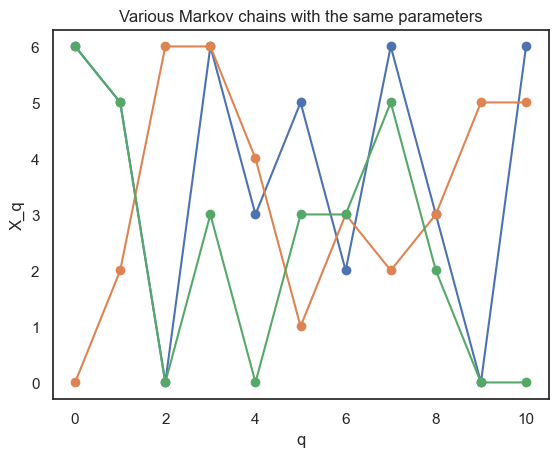

In [54]:
N = 7
n_max = 10

# Differents rhos
random_rho = generate_probability_vector(N)
rho = np.array([1] + [0] * (N-1)) # The chain has to start by the point 0

# Random matrix
A = random_stochastic_matrix(N)
# Print the chosen values
if N <= 7:
    print("A = \n", pd.DataFrame(A), end="\n\n")    

else:
    print("First columns of A : \n", pd.DataFrame(A), end="\n\n")

print("rho = \n", pd.DataFrame(random_rho), end="\n\n")

# Print the result of a simple call
path = markov(random_rho, A, n_max, rng, N)
print("Result of a simple call to Markov function : ", path)

# Call multiple times the function and plot the result
print("Result of multiple calls to Markov function : ")
plot_markov_chain_result(random_rho, A, n_max, rng, N, 3)

3. Explore the potential of the [`multiprocessing` package](https://docs.python.org/3/library/multiprocessing.html) to simulate several Markov chains in parallel.

> Hint: the `mutiprocessing.Pool.starmap` or `mutiprocessing.Pool.starmap_async` methods could be useful.

**Answer:**

In [ ]:
import multiprocessing
import defs

num_simulations = 10
n_max = 10

inputs = [(random_rho, A, n_max, defs.rng, N)] * num_simulations


if __name__ == "__main__":
    # Créez un pool de processus
    pool = multiprocessing.Pool(processes=2)

    # Exécutez les simulations en parallèle
    results = pool.starmap(defs.markov, inputs)

    # Fermez le pool de processus
    pool.close()
    pool.join()

# Fermez le pool de processus
#pool.close()
#pool.join()

# Traitez les résultats comme nécessaire
for i, result in enumerate(results):
    print(f"Résultat de la simulation {i}: {result}")


Résultat de la simulation 0: [1, 0, 5, 0, 1, 0, 1, 4, 0, 4, 1]
Résultat de la simulation 1: [1, 0, 4, 0, 0, 5, 6, 0, 2, 0, 2]
Résultat de la simulation 2: [2, 4, 0, 2, 0, 4, 5, 1, 1, 4, 0]
Résultat de la simulation 3: [3, 4, 1, 0, 4, 6, 4, 0, 4, 1, 4]
Résultat de la simulation 4: [2, 4, 2, 1, 4, 6, 4, 4, 5, 6, 6]
Résultat de la simulation 5: [0, 1, 4, 4, 0, 6, 4, 2, 5, 6, 0]
Résultat de la simulation 6: [2, 2, 4, 0, 5, 0, 2, 4, 6, 5, 6]
Résultat de la simulation 7: [3, 1, 1, 2, 2, 5, 0, 1, 5, 0, 4]
Résultat de la simulation 8: [4, 1, 4, 1, 5, 2, 4, 5, 4, 0, 0]
Résultat de la simulation 9: [2, 5, 0, 0, 0, 2, 4, 4, 0, 5, 4]


4. [Bonus] Generate Markov chains in parallel with the [`dask`](https://docs.dask.org/en/latest/futures.html) library, which offers more general parallelization functionalities (with, for instance, the use of [`Futures`](https://docs.dask.org/en/stable/futures.html), see tutorial [here](https://tutorial.dask.org/05_futures.html)). A useful example is provided [here](https://stackoverflow.com/questions/41471248/how-to-efficiently-submit-tasks-with-large-arguments-in-dask-distributed). Note that `dask` is much more versatile and powerful than `multiprocessing`, and can be useful to scale algorithms over multiple cores and/or computing nodes.

**Answer:**

In [ ]:
# your code

## <a name="bonus">Bonus: Parallel computing with Dask</a> [(&#8593;)](#content)

1. Take a look at the [`dask.array` documentation](https://docs.dask.org/en/stable/array-best-practices.html) and the associate [tutorial](https://tutorial.dask.org/02_array.html). Apply some of the functions introduced herein and in the [documentation](https://docs.dask.org/en/stable/array-best-practices.html) to parallelize the computation of the total variation investigated during session 2. Note that you can combine `dask` and `numba` to obtain an overall more efficient implementation. Note that timing can be worse than Numpy (`dask.array` is more specifically interesting when the data do no fit in memory).

2. Take a look at the [`dask.delayed` tutorial](https://tutorial.dask.org/03_dask.delayed.html), and go through some of the examples provided. [Best practices with the `dask.delayed` interface](https://docs.dask.org/en/stable/delayed-best-practices.html) are summarized in the documentation.

> **Remark**: an alternative to Dask: the [Ray](https://docs.ray.io/en/latest/) library.

**Answer:**

In [ ]:
# your code